In [14]:
#run below code twice
import neural_testbed
from neural_testbed.agents import factories as agent_factories
from neural_testbed.agents.factories.sweeps import testbed_2d as agent_sweeps
from neural_testbed import base
from neural_testbed import generative
from neural_testbed import leaderboard
from typing import Callable, NamedTuple
from line_profiler import LineProfiler

import numpy as np
import pandas as pd
import plotnine as gg
import torch
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax

import warnings
warnings.filterwarnings('ignore')

import pipeline


training data count (500, 2)
meta_loss_list [5.070563507979372e-05, 8.558873550879053e-05, 8.043548747670463e-05, 6.263396851018577e-05, 3.2418660179816833e-05, 4.9754460877960956e-05, 2.7684661126775546e-05, 6.494282121888642e-05, 0.00010779147804803712, 5.728869527789316e-05, 5.665886884871304e-05, 3.731354537715964e-05, 5.915852702003386e-05, 4.964761344002609e-05, 5.965339476738415e-05]


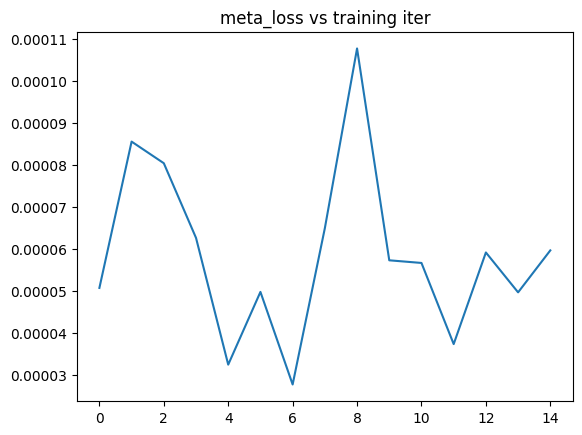

training epoch ends in  8.17 minutes.
meta_loss_list [3.807172522616654e-05, 6.267162699961242e-05, 6.085041553801924e-05, 3.123637104768522e-05, 5.544384584859306e-05, 3.4542761177668675e-05, 4.282404007754036e-05, 3.3662306108862275e-05, 3.333895749527073e-05, 6.691653459376399e-05, 9.986802748104557e-05, 5.469997790260293e-05, 4.66204763437878e-05, 9.193824327574955e-05, 1.858337430461071e-05]


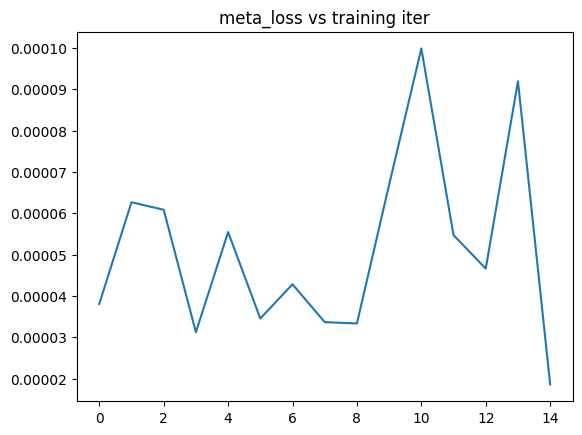

training epoch ends in  8.16 minutes.
meta_loss_list [6.27793412742942e-05, 4.541232378333531e-05, 5.542553577821824e-05, 6.223530429552921e-05, 3.4106907775481414e-05, 3.661974835747505e-05, 2.332978483051318e-05, 4.2454941007996714e-05, 4.3435624751609475e-05, 3.7239698187042144e-05, 9.424530341794633e-05, 3.329836853836017e-05, 3.625555459944158e-05, 9.15301357708035e-05, 0.00010339882873519612]


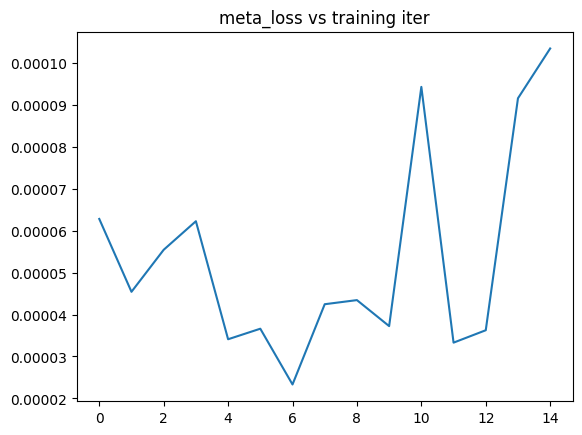

training epoch ends in  8.16 minutes.
meta_loss_list [4.61631937349737e-05, 3.9530672119568845e-05, 6.134856385729887e-05, 2.4037234771338628e-05, 3.7933465552200066e-05, 4.5670698237869475e-05, 5.301886560026784e-05, 0.00012037114806862656, 5.464066242109899e-05, 6.642719941414446e-05, 6.177144726921685e-05, 6.305052792479572e-05, 5.563046733425363e-05, 0.00013286221925432246, 7.51450472947265e-05]


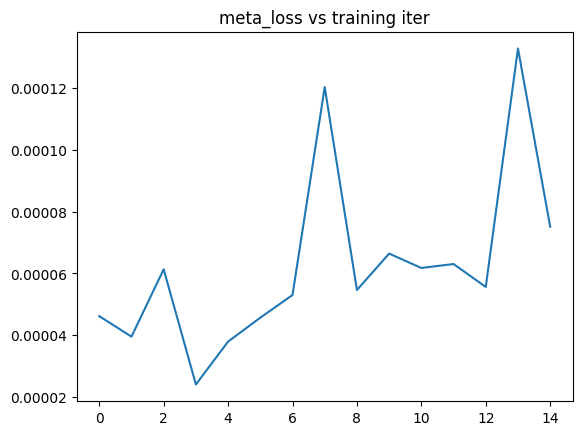

training epoch ends in  8.17 minutes.
meta_loss_list [4.82991446239089e-05, 5.459559609962013e-05, 5.4104697905657225e-05, 5.903994794949157e-05, 4.755407843867331e-05, 7.5224975541551e-05, 4.8732609135686234e-05, 0.00010079916966773499, 0.00015768139127888604, 6.882213551402477e-05, 3.366957162736139e-05, 2.8999622930695563e-05, 8.60159617147708e-05, 0.00010612158754496964, 8.355144229121956e-05]


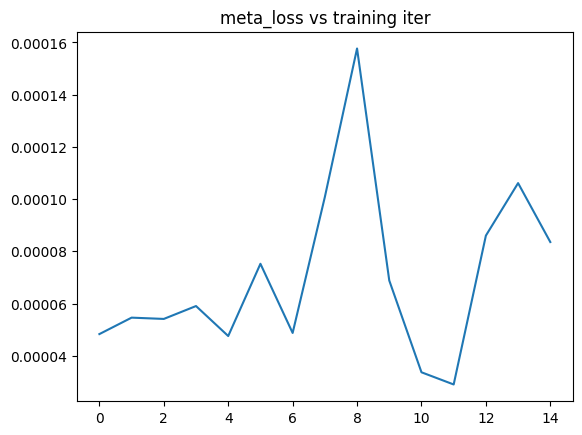

training epoch ends in  8.16 minutes.
meta_loss_list [4.099337755633127e-05, 8.87484170459976e-05, 5.809990775591594e-05, 4.878004653638174e-05, 7.401637791389494e-05, 5.8349098920348116e-05, 3.9130018909256607e-05, 5.699813772169727e-05, 3.645837586843854e-05, 5.993144308902689e-05, 0.00012712110292447906, 0.00013179338657128936, 5.611626673343931e-05, 7.606777064764463e-05, 6.654829311560334e-05]


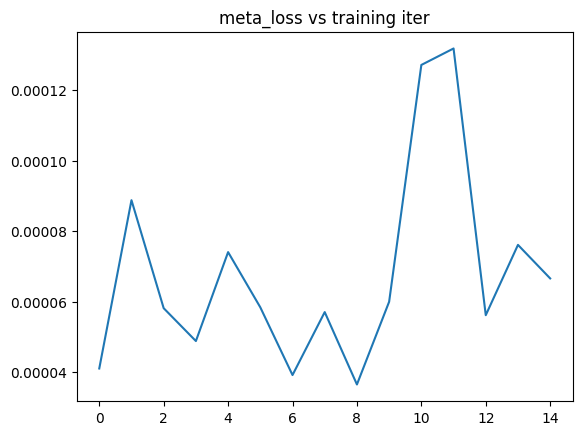

training epoch ends in  8.16 minutes.


In [ ]:
#data generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Dataset_generator.ipynb
#predictor (a logistic regression) generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Predictor.ipynb 
url = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
train_csv_name = url + 'classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
test_csv_name = url + 'classifier_input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
pool_csv_name = url + 'classifier_input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'


df_train = pd.read_csv(train_csv_name)
print('training data count',df_train.shape)


dataset_cfg = pipeline.DatasetConfig(train_csv_name, test_csv_name, pool_csv_name, "EVENT_LABEL")
model_cfg = pipeline.ModelConfig(batch_size_train = 64, batch_size_test = 64, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.001, n_classes = 2, n_epoch = 10, init_train_lr = 0.001, init_train_weight_decay = 0.1, n_train_init = 20)
train_cfg = pipeline.TrainConfig(n_train_iter = 15, n_ENN_iter = 15, ENN_opt_lr = 0.001, temp_var_recall = 0.4) #temp_var_recall is the new variable added here
enn_cfg = pipeline.ENNConfig(basenet_hidden_sizes = [50,50],  exposed_layers = [False, True], z_dim = 8, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5,5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 0.1)
 

model_predictor = torch.jit.load(url + 'predictor.pt')
model_predictor.eval()

# Example usage
#need to add ``pipeline.'' in the below command; I didn't add it so that I can debug more easily
experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, if_print = 1)

meta_loss_list [6.1641803376207e-05, 6.904127732059936e-05, 9.043505181108595e-05, 5.196906037600716e-05, 3.523617926375869e-05, 5.487340529907012e-05, 2.7131839759889564e-05, 5.444458750655172e-05, 8.48958634386348e-05, 6.767571224003692e-05, 4.8853967121877985e-05, 5.038367309340586e-05, 4.2786838588034035e-05, 5.517699058551714e-05, 4.9632456729824834e-05]


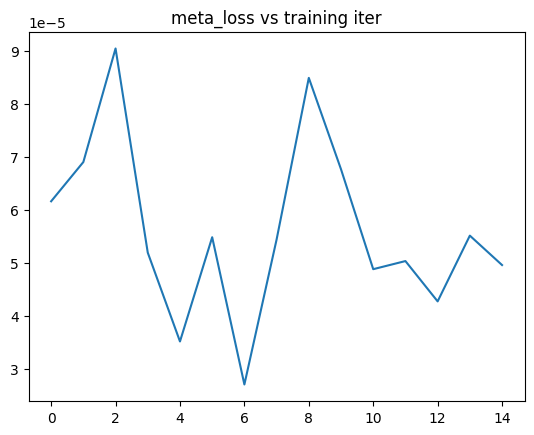

training epoch ends in  11.9 minutes.
test starts


In [19]:
#%load_ext line_profiler
#profiling code - check which part
#%reload_ext line_profiler

#%lprun -f experiment experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, if_print = 1)